In [1]:
import pandas as pd
import numpy as np
from shared import demand as dmd
import matplotlib.pyplot as plt

In [2]:
df = dmd.create_ds()
df

,demand,product_category_name
order_purchase_timestamp,,
2016-09-15,3,total
2016-09-16,0,total
2016-09-17,0,total
2016-09-18,0,total
2016-09-19,0,total
...,...,...
2018-08-24,18,utilidades_domesticas
2018-08-25,5,utilidades_domesticas
2018-08-26,9,utilidades_domesticas


Since we're doing experimental work, it's good to only have a train dataset at this point.
Let's preserve 2018 for a hold-out set.

In [3]:
df = df.loc['2017-01-01':'2017-12-31',:]

Let's first construct some seasonality stuff

<AxesSubplot:xlabel='order_purchase_timestamp'>

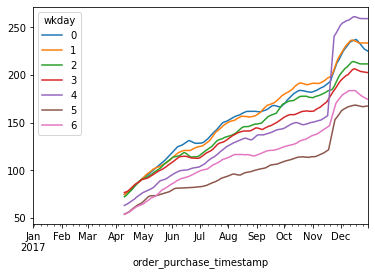

In [4]:
total = df[df['product_category_name'] == 'total'].copy()
total['wkday'] = total.index.weekday
by_weekday = total.reset_index().pivot(columns='wkday', values='demand', index='order_purchase_timestamp')
by_weekday = by_weekday.fillna(method='bfill').fillna(method='ffill')
by_weekday.rolling(100).mean().plot()

Some steady differences across weekdays. The largest outlier spike occurrs on a friday apparently.
This seems like an anomalous event, that is unpredictable without more knowledge of the business so let's treat it as such.

In [5]:
total.sort_values('demand', ascending=False).head(10)

,demand,product_category_name,wkday
order_purchase_timestamp,,,
2017-11-24,1345,total,4
2017-11-25,569,total,5
2017-11-27,469,total,0
2017-11-26,450,total,6
2017-11-28,427,total,1
2017-12-04,360,total,0
2017-11-29,359,total,2
2017-11-23,326,total,3
2017-12-05,317,total,1


Define outlier days and an outlier week

In [6]:
outlier_day = ['2017-11-24']
outlier_week = pd.date_range('2017-11-23', '2017-11-29')

Let's look at how the demand accumulates over an individual month

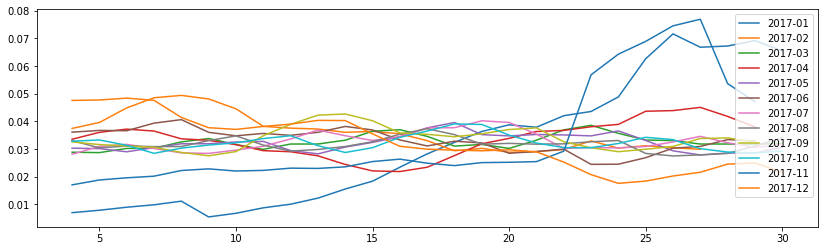

In [51]:
months = [f'2017-{str(i).zfill(2)}' for i in range(1, 13)]
f, ax = plt.subplots(figsize=(14, 4))
for m in months:
    monthdemand = total['demand'][m] / total['demand'][m].sum()
    monthdemand = monthdemand.rolling(5).mean()
    plt.plot(monthdemand.values)
plt.legend(months)

The time of month seems to have very little effect on the demand beyond the first January and the outlier late 2017 values. 

#### Rolling windows / lag variables

In [80]:
def plot_with_without_outliers(roll_data):
    plt.plot(roll_data.corr()['demand'].values)
    plt.plot(roll_data[:'2017-11-15'].corr()['demand'].values)
    plt.legend(['with outlier', 'without outliers'])

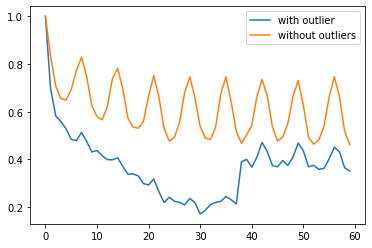

In [85]:
# independent autocorrelations
roll_data = total[['demand']].copy()
for i in range(1, 60):
    roll_data[f'lag_{i}'] = roll_data['demand'].shift(i)
plot_with_without_outliers(roll_data)

Trending variable so the high positive auto-correlations are intuitive. Weekday pattern clearly visible.

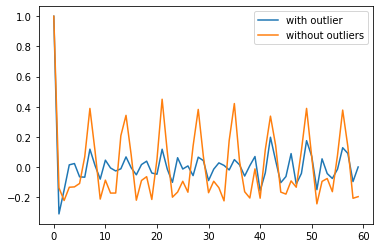

In [86]:
# independent autocorrelations on differences
roll_data = total[['demand']].diff().copy()
for i in range(1, 60):
    roll_data[f'lag_{i}'] = roll_data['demand'].shift(i)
plot_with_without_outliers(roll_data)

Differenced mostly reflect the weekly pattern.

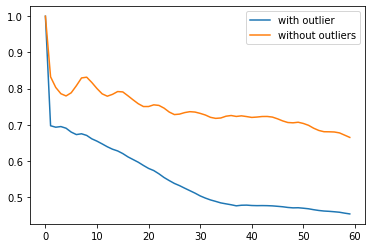

In [88]:
roll_data = total[['demand']].copy()
for i in range(1, 60):
    roll_data[f'lag_{i}'] = roll_data['demand'].rolling(i).mean().shift(1)
plot_with_without_outliers(roll_data)

8 day rolling window seems feasible for the daily forecasting task

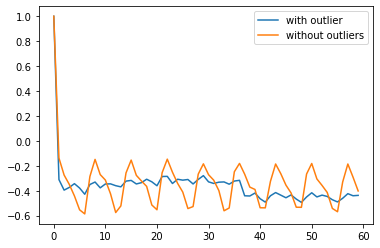

In [89]:
roll_data = total[['demand']].diff().copy()
for i in range(1, 60):
    roll_data[f'lag_{i}'] = roll_data['demand'].rolling(i).mean().shift(1)
plot_with_without_outliers(roll_data)

Large negative autocorrelation in rolling average in differenced series.

In [ ]:
# independent autocorrelations on differences
roll_data = total[['demand']].diff().copy()
for i in range(60):
    roll_data[f'lag_{i}'] = roll_data['demand'].shift(i)
plt.plot(roll_data.corr()['demand'].values)

### Review data
The review data is problematic in the sense, that there might be a lot of endogenous stuff going on. 

For example with a lot of orders, we  (this is testable with the data)

In [10]:
reviews = pd.read_csv('tempdata/olist_order_reviews_dataset.csv')
reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


We have review scores available for all reviews.
The review comment messages could provide additional information, especially when doing something like causal analysis. 
However, as it's likely to not introduce much useful information for demand forecasting beyond the review scores, we can avoid the hassle for now.

To make sure, info is available ex-ante, we should use review creation date as the collecting variable to construct a review sentiment time series.

In [11]:
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])

<AxesSubplot:xlabel='review_creation_date'>

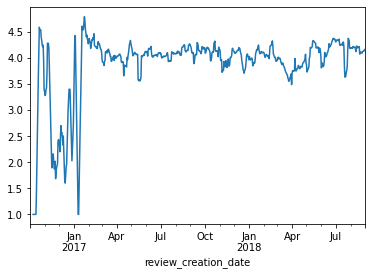

In [12]:
review_features = reviews.set_index('review_creation_date').resample('d')['review_score'].agg('mean')
review_features = review_features.fillna(method='ffill')
review_features.rolling(7).mean().plot()

The number of reviews couuld potentially be related to further demand as well.
However, because the data is sampled in a biased way, so that for each order there is a review.
Because of this, the count of reviews in fact just reflects lagged demand.
The review scores are thus more relevant in this case.

There seems to be some variation over time in the review scores, but a lot of noise.

In [13]:
# Contemporaneous daily correlation

total.join(review_features).corr()


,demand,wkday,review_score
demand,1.000000,-0.155824,0.124298
wkday,-0.155824,1.000000,-0.238599
review_score,0.124298,-0.238599,1.000000


In [14]:
# Ex-ante daily correlation
total.join(review_features.shift(1)).corr()

,demand,wkday,review_score
demand,1.000000,-0.155824,0.079754
wkday,-0.155824,1.000000,0.094390
review_score,0.079754,0.094390,1.000000


In [15]:
# ex-ante correlation over a longer horizon
total.join(review_features.shift(1))[['demand','review_score']].rolling(30).mean().corr()

,demand,review_score
demand,1.00000,-0.08593
review_score,-0.08593,1.00000


In [16]:
# ex-ante correlation over a longer horizon
total[['demand']].diff().join(review_features.shift(1)).rolling(30).mean().corr()

,demand,review_score
demand,1.000000,-0.109682
review_score,-0.109682,1.000000


In [17]:
total[['demand']].diff().join(review_features.shift(1)).corr()

,demand,review_score
demand,1.000000,-0.046652
review_score,-0.046652,1.000000


No clear correlation between ex-ante reviews and review scores, so likely we'll introduce noise by using this info.

The more likely use for reviews could be something like looking at product specific ones.
However, as demand for individual products seems too noisy to model, that is not a priority.
Let's still take a look at reviews by category.

In [18]:
order_items = pd.read_csv('tempdata/olist_order_items_dataset.csv')
products = pd.read_csv('tempdata/olist_products_dataset.csv')

In [19]:
review_by_category = order_items[['order_id','product_id']].merge(reviews[['order_id','review_score','review_creation_date']])
review_by_category = review_by_category.merge(products[['product_id','product_category_name']])
review_by_category = review_by_category.set_index('review_creation_date') 
review_by_category = review_by_category.groupby('product_category_name')['review_score'].resample('d').agg('mean')
review_by_category = review_by_category.reset_index()

In [20]:
review_by_category = review_by_category.pivot(columns='product_category_name',index='review_creation_date', values='review_score').fillna(method='ffill')

<AxesSubplot:xlabel='review_creation_date'>

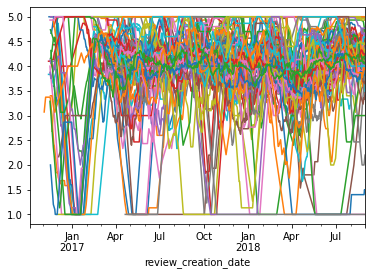

In [21]:
review_by_category.rolling(30).mean().plot(legend=False)

The category specific reviews seem mostly too noisy to be useful. For larger categories this could be something to experiment with down the line, 
but for now let's ignore it.